## 형태소 분석

In [58]:
import os
import re
import pandas as pd
from khaiii import KhaiiiApi

# 데이터프레임을 리스트로 변경하는 함수
def dataframe_to_list(df, column_name):
    return df[column_name].astype(str).tolist()

# 텍스트 전처리 함수
def text_preprocess(text):
    # span tag 제거
    text = re.sub(r"<span[^>]*>", "", str(text))
    text = re.sub(r"</span>", "", text)
    # br tag 삭제
    text = re.sub(r"<br[/]?>", "", text)
    # 영어, 한글, 숫자, 온점 제외 삭제
    text = re.sub(r"[^0-9가-힣A-Za-z. ]", "", text)
    # 온점을 구분으로 문장 구분
    sentences = [sen.strip() for sen in text.split('.') if sen.strip()]
    return sentences

# CSV 파일들이 있는 디렉토리 경로
directory = './data'

# 'comments_'로 시작하는 모든 CSV 파일 경로 찾기
csv_files = [file for file in os.listdir(directory) if file.startswith('comments_') and file.endswith('.csv')]

# DataFrame 초기화
total_df = pd.DataFrame()

# CSV 파일들을 읽어들여 DataFrame에 추가
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, encoding='utf-8-sig')
    total_df = pd.concat([total_df, df], ignore_index=True)

# 'Comment' 열과 'Likes' 열을 리스트로 변환
comment_list = dataframe_to_list(total_df, 'Comment')
likes_list = dataframe_to_list(total_df, 'Likes')


In [59]:
import csv

def create_csv_from_dataframe(dataframe, column_name, output_csv_path):
    comment_list = dataframe[column_name].tolist()
    with open(output_csv_path, 'w', encoding='utf-8-sig', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([column_name])
        writer.writerows([[comment] for comment in comment_list])

# 출력 CSV 파일 경로
output_csv_path = './data/comments.csv'

# total_df 데이터프레임의 'Comment' 열을 CSV 파일로 저장
create_csv_from_dataframe(total_df, 'Comment', output_csv_path)


In [70]:
api = KhaiiiApi()
nng_counts_with_likes = {}  # likes 수를 고려한 NNG 단어의 개수를 저장할 딕셔너리
nng_counts_without_likes = {}  # likes 수를 고려하지 않은 NNG 단어의 개수를 저장할 딕셔너리

stop_words = ["때", "요즘", "잔망", "트", "지", "진짜", "가요계", "아이돌", "피", "영지", "거", "이", "전", "투샷"]

for sentence_with_likes in zip(comment_list, likes_list):
    sentence, likes = sentence_with_likes[0], sentence_with_likes[1]
    if pd.notnull(likes) and str(likes).replace(".", "").isdigit():  # NaN 값 및 소수 확인
        sentences = text_preprocess(sentence)
        for sentence in sentences:
            for word in api.analyze(sentence):
                for morph in word.morphs:
                    if morph.tag == 'NNG' and morph.lex not in stop_words:
                        lex = morph.lex
                        if lex in nng_counts_with_likes:
                            nng_counts_with_likes[lex] += int(float(likes))
                        else:
                            nng_counts_with_likes[lex] = int(float(likes))
                        
                        if lex in nng_counts_without_likes:
                            nng_counts_without_likes[lex] += 1
                        else:
                            nng_counts_without_likes[lex] = 1

# 내림차순으로 정렬
sorted_counts_with_likes = sorted(nng_counts_with_likes.items(), key=lambda x: x[1], reverse=True)
sorted_counts_without_likes = sorted(nng_counts_without_likes.items(), key=lambda x: x[1], reverse=True)

# 상위 50개 단어 추출
top_50_with_likes = sorted_counts_with_likes[:50]
top_50_without_likes = sorted_counts_without_likes[:50]

# 상위 50개 단어 출력
print("Top 50 Words with Likes:")
for word, count in top_50_with_likes:
    print(word, count)

print("Top 50 Words without Likes:")
for word, count in top_50_without_likes:
    print(word, count)

# 결과를 CSV 파일로 저장
df_with_likes = pd.DataFrame(top_50_with_likes, columns=['Word', 'Count'])
df_with_likes.to_csv('result_with_likes.csv', index=False, encoding="utf-8-sig")

df_without_likes = pd.DataFrame(top_50_without_likes, columns=['Word', 'Count'])
df_without_likes.to_csv('result_without_likes.csv', index=False, encoding="utf-8-sig")


Top 50 Words with Likes:
출산 70142
생각 40826
나라 40509
정치인 37030
회장 35270
건강 29676
위기 27811
진심 27392
애 26519
문제 25635
애기 24117
국민 22743
아이 22649
사람 22541
해결 21424
사랑 20600
사회 19916
진행 19128
사태 18884
속도 18742
감사 17563
자극 16990
소비자 16732
행복 15956
성인 15819
미래 15281
집값 15209
세대 15019
성장 14784
쌍둥이 14580
감정 13961
아기 13952
세구 13726
돈 13160
부모 12967
노인 12850
일 12769
국회의원 12655
얘기 12554
말 12443
정책 12130
응원 12124
아가 12086
겨냥 11757
결혼 11701
안정 11658
직장 11412
함 11224
지원 10946
완구 10874
Top 50 Words without Likes:
출산 4919
나라 4180
애 3915
사람 2635
돈 2480
생각 2298
결혼 2290
문제 2243
회장 2181
아이 1929
말 1606
일 1555
사회 1551
기업 1495
인구 1398
여자 1378
국민 1298
정책 1285
지원 1192
국가 1157
해결 1152
정부 1044
남자 1003
정치인 982
회사 980
집 962
세대 909
정치 906
이상 890
지금 804
여성 803
집값 769
세금 711
노인 692
미래 668
부모 651
쌍둥이 639
행복 600
우리나라 600
현실 592
세계 580
시대 548
자식 538
걱정 531
정도 531
경제 528
세상 517
필요 517
국회의원 511
가능 477


## 3. wordcloud 생성

In [71]:
text = " ".join(li for li in df_with_likes['Word'].astype(str))
text

'출산 생각 나라 정치인 회장 건강 위기 진심 애 문제 애기 국민 아이 사람 해결 사랑 사회 진행 사태 속도 감사 자극 소비자 행복 성인 미래 집값 세대 성장 쌍둥이 감정 아기 세구 돈 부모 노인 일 국회의원 얘기 말 정책 응원 아가 겨냥 결혼 안정 직장 함 지원 완구'

In [402]:
!pip install wordcloud

In [72]:
from collections import Counter # 빈도 수 세기
from wordcloud import WordCloud, STOPWORDS # wordcloud 만들기
import pandas as pd
import matplotlib.pyplot as plt # 시각화
import matplotlib as mp

In [73]:
#워드클라우드를 위해 데이터 불러오기

def make_word(filename):
    word_dict = {}
    df = pd.read_csv(w_file)
    word_dict = df.set_index("Word").T.to_dict()
    
    for key,value in word_dict.items():
        word_dict[key] = value["Count"]   
        
    return word_dict

## wordcloud 만들기

In [74]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def make_wordcloud(word, font_file, title):
    spwords = set(STOPWORDS)  # 기본적으로 많이 쓰는 단어 (제외할 단어)
    # spwords.add('진짜')  # 제외하고 싶은 단어 추가

    wc = WordCloud(stopwords=spwords, font_path=font_file, width=800, height=800, scale=5.0, max_font_size=200)
    gen = wc.generate_from_frequencies(word)

    plt.figure()
    plt.axis("off")  # 축 제거
    plt.title(title)
    plt.imshow(gen)
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

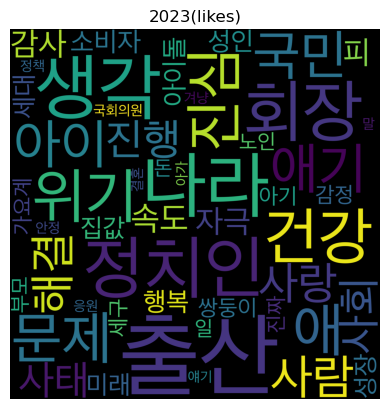

 50%|█████     | 1/2 [00:01<00:01,  1.76s/it]

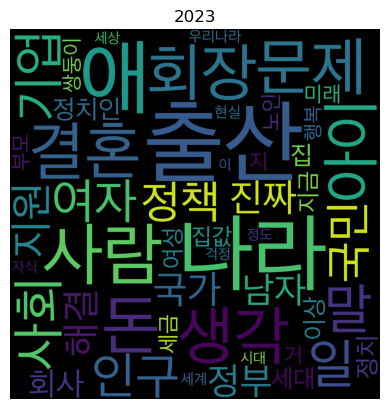

100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


In [75]:
######################## 워드 cloud만들기 메인

# pc마다 환경달라서 폰트 뺌
font_file = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
w_directory = "./fromkhaiii/"

# csv파일, title 딕셔너리에 추가해서 한꺼번에 돌립니다.
plot_dict ={
    # 2023년 저출산
    "result_with_likes_2023.csv"    : "2023(likes)",
    "result_without_likes_2023.csv" : "2023",
}

for key, value in tqdm(plot_dict.items()):
    w_file = w_directory + key
    title = plot_dict[key]
    make_wordcloud(make_word(w_file), font_file, title)